In [1]:
import numpy as np
import math
import operator
import networkx as nx
from itertools import permutations
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms,gp
import dimod
import dwave_networkx as dnx
import import_ipynb
import tsp_parser
from tsp_parser import read_tsp_file
from operator import itemgetter
import pygraphviz as pgv
from IPython.display import Image 
import copy

importing Jupyter notebook from tsp_parser.ipynb
importing Jupyter notebook from city.ipynb


In [2]:
tsp = read_tsp_file('./symmetric_problems/berlin52.tsp')

In [3]:
len(tsp['CITIES'])

52

In [4]:
def plotGraph(G,show_weights=False):
    pos=nx.get_node_attributes(G,'coord')
    nx.draw(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    if show_weights:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [5]:
def distance(A, B): 
    "The Euclidean distance between two cities."
    return math.sqrt( ((A[0]-B[0])**2)+((A[1]-B[1])**2) )

In [6]:
def total_distance(G):
    total =0
    for edge in G.edges: 
        total += distance(G.nodes[edge[0]]["pos"],G.nodes[edge[1]]["pos"])
    return total

In [7]:
G = nx.Graph()
G=nx.complete_graph(52)

In [8]:
for index,city in enumerate(tsp['CITIES']):
    G.nodes[index]['pos'] = (city.x,city.y)

In [9]:
nx.set_edge_attributes(G, values = 1, name = 'weight')

In [10]:
#G.add_weighted_edges_from({(0, 1,0.1), (0, 2, .5), (0, 3, .1), (1, 2, .1),(1, 3, .5), (2, 3, .1)})

In [11]:
G.is_directed()

False

In [12]:
G.has_edge(1,0)

True

In [13]:
solution =[0]

In [14]:
def near(edges,solution):
    distances =[]
    for edge in edges:      
        if edge[1] not in solution:
            distances.append({"distance":distance(G.nodes[edge[0]]['pos'],G.nodes[edge[1]]['pos']),"node":edge[1]}) 
    nearest = min(distances, key=lambda x:x['distance'])
    solution.append(nearest['node'])
    return nearest 

In [15]:
for node in range(51):
    near(G.edges(solution[len(solution)-1]),solution)

In [16]:
solution.append(solution[0])

In [17]:
# pos=nx.get_node_attributes(G,'pos')
# nx.draw(G,pos,with_labels=True)
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
# plt.show()

In [18]:
G.clear_edges()

In [19]:
for index in range(len(solution)-1):
    #print(solution[index],solution[index+1])
    G.add_edge(solution[index],solution[index+1])

In [20]:
def plotGraph(G,show_weights=False):
    
    color_map = []
    node_sizes = []
    for node in G:
        if node == "center":
            color_map.append('red')
            node_sizes.append(800)
            
        else: 
            color_map.append('#6b61f4')
            node_sizes.append(300)

        
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G,pos,node_color=color_map,node_size = node_sizes,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    if show_weights:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

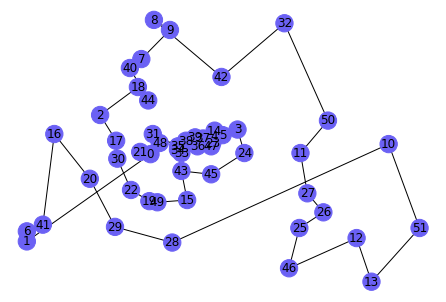

In [21]:
plotGraph(G)

In [22]:
print(total_distance(G))

8980.91827932919


### GENETIC ALGORITHM

In [ ]:
toolbox = base.Toolbox()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [ ]:
toolbox.register("indices", np.random.permutation, len(tsp['CITIES']))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

In [ ]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

In [34]:
def create_tour(individual):
    G = nx.Graph()
    G=nx.complete_graph(len(individual))
    G.clear_edges()
    for index,city in enumerate(tsp['CITIES']):
        G.nodes[index]['pos'] = (city.x,city.y)
        
    for index in range(len(individual)-1):
        G.add_edge(individual[index],individual[index+1])
    G.add_edge(individual[len(individual)-1],individual[0])
    
    return G

In [33]:
def evaluation(individual):
    return (total_distance(create_tour(individual)),)

In [ ]:
toolbox.register("evaluate", evaluation)

In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
pop = toolbox.population(n=100)

In [ ]:
plotGraph(create_tour(pop[2]))

In [ ]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

In [ ]:
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=400, verbose=False,stats=fit_stats)

In [ ]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

In [ ]:
G = create_tour(best_individual)

In [ ]:
plotGraph(G)

In [ ]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');
plt.title("berlin52 symetric graph")

In [35]:
def GraphCentroid(G):
    x = [G.nodes[p]['pos'][0] for p in G.nodes]
    y = [G.nodes[p]['pos'][1] for p in G.nodes]
    centroid = (sum(x) / len(G.nodes), sum(y) / len(G.nodes))
    return centroid

In [36]:
def GraphStd(G):
    x = [G.nodes[p]['pos'][0] for p in G.nodes]
    y = [G.nodes[p]['pos'][1] for p in G.nodes]
    return np.std([x,y],axis=0)

In [ ]:
graph_std = GraphStd(G)

In [ ]:
graph_std[0]

In [ ]:
GraphCentroid(G)

In [ ]:
G.add_node("center",pos=(GraphCentroid(G)))

In [ ]:
plotGraph(G)

In [ ]:
G.remove_node("center")

### GENETIC PROGRAMMING

In [23]:
def Div(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

In [24]:
def Mod(left, right):
    try:
        return left % right
    except ZeroDivisionError:
        return 1

In [25]:
pset = gp.PrimitiveSet("MAIN",6)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(Mod, 2)
#Number of nodes in the graph
pset.renameArguments(ARG0="Nn")
#Number of remaining nodes to visit
pset.renameArguments(ARG1="Nrn")
#Distance from the current node
pset.renameArguments(ARG2="Dcn")
#Distance from the initial node
pset.renameArguments(ARG3="Din")
#Distance from the centroid of the nodes
pset.renameArguments(ARG4="Dc")
#Predicted distance from the initial node
pset.renameArguments(ARG5="Pd")
# #Distance left estimation
# pset.renameArguments(ARG0="Dle")

In [26]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [27]:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [28]:
def euc_distance(A, B): 
    return math.sqrt( ((A[0]-B[0])**2)+((A[1]-B[1])**2))

In [29]:
def nearest_neighbor(current,unvisited_nodes, G):
    min_node = min(unvisited_nodes, key=lambda x: euc_distance(G.nodes[x]["pos"], G.nodes[current]['pos']))
    return min_node

In [37]:
def greedy_TSP(G,visited):
    vis = copy.deepcopy(visited)
    while len(vis) < 52:
        C = nearest_neighbor(vis[-1], np.setdiff1d(list(G.nodes),vis),G)
        vis.append(C)
    vis.append(vis[0])
    score = evaluation(vis)[0]
    return score

In [38]:
greedy_TSP(G,[0])

8980.91827932919

In [39]:
def evaluate(individual,G):
    G.clear_edges()
    tree = gp.PrimitiveTree(individual)
    
    node_results = [0]
    current_node = 0
    initial_node =0
    visited = [0]
    solution = [0]
    for i in range(len(G.nodes)):
        results = []
        for index in range(len(G.nodes)):
            if index not in visited:
                Nn = len(G.nodes())
                Nrn = len(np.setdiff1d(list(G.nodes),visited))
                Dcn = distance(G.nodes[current_node]["pos"],G.nodes[index]["pos"])
                Din = distance(G.nodes[initial_node]["pos"],G.nodes[index]["pos"])
                Dc = distance(GraphCentroid(G),G.nodes[index]["pos"])
                Pd = greedy_TSP(G,visited)
                result = toolbox.compile(expr=individual)
                results.append({"result": result(Nn,Nrn,Dcn,Din,Dc,Pd),"node":index})
        if not results:
            break
        nearest = min(results, key=lambda x:x['result'])
        G.add_edge(current_node,nearest["node"])
        solution.append(nearest["node"])
        current_node = nearest["node"]
        visited.append(nearest["node"])

    G.add_edge(initial_node,solution[len(solution)-1])
    return total_distance(G),

In [41]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=2, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evaluate, G= G)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [42]:
toolbox.individual()

In [ ]:
toolbox.mutate()

In [ ]:
pop = toolbox.population(n=10)

In [ ]:
# stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
# stats_size = tools.Statistics(len)
# mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
# mstats.register("avg", np.mean)
# mstats.register("std", np.std)
# mstats.register("min", np.min)
# mstats.register("max", np.max)

fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

In [ ]:
pop, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=15,stats=fit_stats,verbose=True)

In [ ]:
log.select('min')

In [ ]:
best_individual = tools.selBest(pop, k=1)[0]
print(best_individual.height)
nodes, edges, labels = gp.graph(best_individual)
# print('Fitness of the best individual: ', evaluation(best_individual)[0])

g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("./figures/tree.png")

pil_img = Image(filename='./figures/tree.png')
display(pil_img)

In [ ]:
log.select('min')

In [ ]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');
plt.title("berlin52 symetric graph")

In [ ]:
tree = gp.PrimitiveTree(pop[14]) 
string_tree = str(tree)
print(string_tree)

Div(Mod(Nn, sub(Nrn, Pd)), add(mul(Nrn, Din), Dcn))


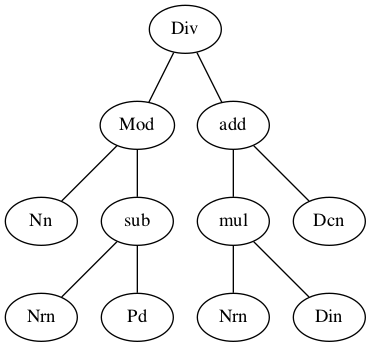

In [48]:
expr = toolbox.individual()

nodes, edges, labels = gp.graph(expr)

tree = gp.PrimitiveTree(expr)
string_tree = str(tree)
print(string_tree)

# nodes, edges, labels = gp.graph(best_individual)
# print('Fitness of the best individual: ', evaluation(best_individual)[0])

g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("./figures/tree.png")

pil_img = Image(filename='./figures/tree.png')
display(pil_img)

In [ ]:
individual = toolbox.individual()
evaluate(individual,G)

In [ ]:
def plotGraph(G,show_weights=False):s
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    if show_weights:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [ ]:
plotGraph(G)